# Mini-projet Monte Carlo - Options Basket

L'objectif de ce mini projet est de calculer grâce à la méthode de Monte-Carlo le prix d'un call sur indice de prix $\mathrm{I}_{t}$ tel que $\forall t \in [0;T]$, $\mathrm{I}_{t} = a_{1} S_{t}^{1} + ... a_{d} S_{t}^{d}$.    
On fais les hypothèses suivantes :   
On a $d \geq 1$ actifs financiers suivant tous un modèle de Black-Scholes tel que l'actif $i$ soit solution de l'EDS de Black-Scholes suivantes :   
$$
\begin{equation*}
    \mathrm{d}S_{t}^{i} = r S_{t}^{i} \mathrm{d}t + \sigma_{i} S_{t}^{i} \mathrm{d}W_{t}^{i} \\
    S^{i}_{0} = s^{i}_{0} \in \mathbb{R}
\end{equation*}
$$
avec :   
- $\mathrm{T} > 0$ la maturité de l'option
- $r>0$ le taux d'intérêt commun à tous les actifs   
- $\sigma_{i}$ la volatilité propre du $i$-ème actif   
- $(W_{t})_{ \{ t \in \in [0;T] \} }$ est un mouvement brownien multidimensionnel sur $\mathbb{R}^{d}$ tel que :   
$\forall (i,j) \in [1,d]^{2}$ tel que $i \ne j$, $d<W^{i},W^{j}>_{t} = \rho_{i,j} \mathrm{d}t$   

Nous rajouterons les hypothèses suivantes :
- Tous les actifs ont la même volatilité $\sigma$     
- Tous les actifs ont la même valeur initiale :    
    $S_{0}^{1} = ... = S_{0}^{d}$
- Le basket d'assets est composé de la même proportion d'actifs :   
    $a_{1} = a_{2} = ... = a_{d} = a = \frac{1}{d}$   
- Tous les mouvements browniens sont corrélés du même coefficient $\rho$ :   
    $\forall (i,j) \in [1,d]^{2}, i \ne j$, $d<W^{i},W^{j}>_{t} = \rho \mathrm{d}t$       

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
### paramètres "physique"
d = 5
T = 1
r = 0.1
S0 = 100
sigma = 0.3
rho = 1/2
K = 105

### paramètres "numériques"
N = 100*T
Mc = 10000000
a = 1/d

## Construction du mouvement brownien
Ici on va s'intéresser à comment construire le mouvement brownien. En effet étant le processus stochastique phare, il est nécessaire de savoir générer une tractoire avant de pouvoir penser à faire autre chose. Pour ça on utiliser la définition sous forme de processus gaussien.    
En effet on sait que $W$ est un mouvement brownien si et seulement si il s'agit d'un processus gaussien continu centrée et de fonction de covariance $K(s,t) = min(s,t)$.   

Ici on va découper notre intervalle $[0,T]$ avec une suite $(t_{i})_{ \{0 \leq i \leq N\}}$ tel que $0 \leq t_{0} < t_{1} < ... < t_{N} = T$. Donc générer un mouvement brownien reviens à générer un vecteur aléatoire $W = \bigl( W_{t_{0}} , ... , W_{t_{N}} \bigr)$. tel que le vecteur soit gaussien et de matrice de variance covariance $\Gamma$ avec $\Gamma_{i,j} = min(t_{i},t_{j})$.   
Maintenant il faut penser à comment générer ce vecteur. L'idée la plus simple et de se dire que comme W est un vecteur gaussien centré, il existe une matrice $A \in \mathbb{M}_{N+1}(R)$ tel que $ W = AZ $ avec $Z \sim \mathcal{N}(0,I_{N+1})$. 
    
Maintenant on cherche donc A tel que $A A^{T} = \Gamma$. Etant donné que $\Gamma$ est symétrique définie positive (si on ne compte pas la première ligne et la première colonne) alors une idée naturelle est de déterminer $A$ grâce à l'algorithme de Cholesky.

In [4]:
## Ici on construit la matrice de variance-covariance du mouvement brownien
def MatBrownien(t,N):
    Mat = np.zeros( (N+1,N+1) )
    for i in range(1,N+1):
        for j in range(1,N+1):
            Mat[i][j] = min(t[i],t[j])
    return Mat 

## Ici on crée le vecteur W qui est censé représenter un mouvement brownien sur l'intervalle [0,T]
def MvmtBrownien(T,N):
    h = T/N
    W = np.random.normal(0,1, size = N+1)
    t = np.array([i*h for i in range(N+1)])
    Mat = MatBrownien(t,N)
    A = np.linalg.cholesky(Mat[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    W = np.dot(B,W)
    return (t,W)

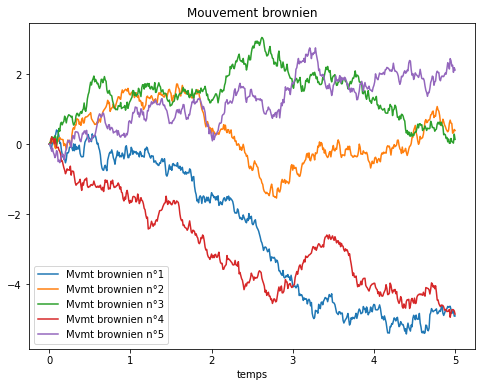

In [52]:
plt.subplots(figsize=(8,6))
for i in range(d):
    t,W = MvmtBrownien(T,N)
    plt.plot(t,W, label = "Mvmt brownien n°{}".format(i+1))
plt.xlabel("temps")
plt.title("Mouvement brownien")
plt.legend()
plt.show()

On a vu comment générer un mouvement brownien. Bien sûr on peut généraliser cette génération en créant une matrice de mouvements browniens indépendants tel que chaque ligne corresponde à un mouvement brownien.   
i.e : Si on appelle $\mathbb{G}$ cette matrice, on a : 
$$
\mathbb{G} = \begin{pmatrix}
W_{t_{0}}^{1} & W_{t_{1}}^{1} & \cdots & W_{t_{N}}^{1}\\
W_{t_{0}}^{2} & W_{t_{1}}^{2} & \cdots & W_{t_{N}}^{2}\\
\vdots & \vdots & \ddots & \vdots \\
W_{t_{0}}^{d} & W_{t_{1}}^{d} & \cdots & W_{t_{N}}^{d}\\
\end{pmatrix} = \begin{pmatrix}
0 & W_{t_{1}}^{1} & \cdots & W_{t_{N}}^{1}\\
0 & W_{t_{1}}^{2} & \cdots & W_{t_{N}}^{2}\\
\vdots & \vdots & \ddots & \vdots \\
0 & W_{t_{1}}^{d} & \cdots & W_{t_{N}}^{d}\\
\end{pmatrix}
$$

In [5]:
def dMouvementBrownien(d,T,N):
    h = T/N
    W = np.random.normal(0,1, size = (d,N+1))
    t = np.array([i*h for i in range(N+1)])
    Mat = MatBrownien(t,N)
    A = np.linalg.cholesky(Mat[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    for i in range(d):
        W[i] = np.dot(B,W[i])
    return (t,W)

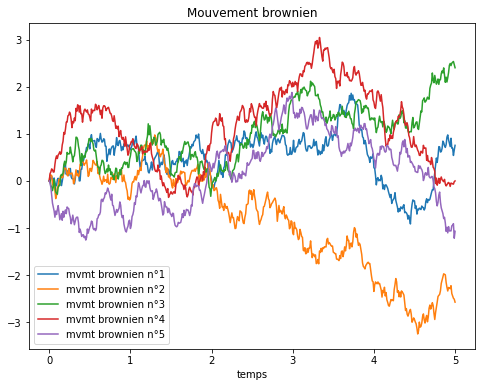

In [53]:
t, W = dMouvementBrownien(d,T,N)
plt.subplots(figsize=(8,6))
for i in range(5):
    plt.plot(t,W[i], label = "mvmt brownien n°{}".format(i+1))
plt.xlabel("temps")
plt.title("Mouvement brownien")
plt.legend()
plt.show()

## Construction de d-mouvements browniens corrélés
Maintenant qu'on sait générer d-mouvement brownien, on s'intéresse à comment réussir à les corréler selon nos envies.   
On souhaite qu'ils soient tous corrélés du même facteur $\rho$.   
i.e : $\forall (i,j) \in [1,d]$ tel que $ i \ne j$ 
$$
\begin{equation*}
    \rho t =  Cov \bigl( W_{t}^{i} , W_{t}^{j} \bigr) 
\end{equation*}
$$
Comme cette condition est vrai $\forall t \in \mathbb{R}^{+}$, alors elle est aussi vérifié à chaque instant de notre discrétisation temporelle.    
On peut donc considérer un instant $t_{k}$ de notre discrétisation ainsi qu'un vecteur aléatoire $Z_{t_{k}} = \bigl( W_{t_{k}}^{1}, ... , W_{t_{k}}^{d} \bigr)$. Il s'agit d'un vecteur gaussien centré de matrice de variance covariance $t_{k} I_{d}$.    
Notre objectif est que connaissant ce vecteur $Z_{t_{k}}$, on veut générer un vecteur $Z^{'}_{t_{k}}$ qui soit de matrice de variance covariance $\Gamma_k$ tel que : 
$$
\Gamma_k = \begin{pmatrix}
t_{k} & \rho t_{k} & \cdots & \rho t_{k} \\
\rho t_{k} & t_{k} & \cdots & \rho t_{k} \\
\vdots & \vdots & \ddots & \vdots \\
\rho t & \rho t_{k} & \cdots & t_{k}
\end{pmatrix} = t_{k} \begin{pmatrix}
1 & \rho  & \cdots & \rho  \\
\rho  & 1 & \cdots & \rho  \\
\vdots & \vdots & \ddots & \vdots \\
\rho  & \rho  & \cdots & 1
\end{pmatrix} = t_{k} \Gamma^{'}
$$
Donc on va chercher une matrice $A_{k}$ tel que $Z^{'}_{t_{k}} = A_{k} Z_{t_{k}}$. On en déduit donc la condition suivante sur $A_{k}$ :
$$
\begin{equation*}
     A_{k} t_{k} I_{d} A_{k}^{T} = t_{k} A_{k} A_{k}^{T} = \Gamma_{k} = t_{k} \Gamma^{'} \\
     A_{k} A_{k}^{T} = \Gamma^{'}
\end{equation*}
$$
Si on arrive à montrer qu'une telle décomposition de $\Gamma^{'}$ existe, on pourra donc calculer $A_{k}$ à partir de de $\Gamma^{'}$.

### Conditions sur $\rho$
Pour appliquer Cholesky sur $\Gamma^{'}$ il y'a des conditions à vérifier. La première étant que la matrice soit symétrique ce qui est - par déf de $\Gamma^{'}$ - le cas. La seconde est que la matrice soit définie positive ce qui peut poser problème.   
En effet comme nous sommes dans un cas particulier où les corrélatations $\rho$ entre les actifs sont les mêmes, on se retrouve avec la matrice suivante : 
$$
\Gamma^{'} = \begin{pmatrix}
1 & \rho  & \cdots & \rho  \\
\rho  & 1 & \cdots & \rho  \\
\vdots & \vdots & \ddots & \vdots \\
\rho  & \rho  & \cdots & 1
\end{pmatrix} 
$$
On se rend donc très vite compte que selon les valeurs de $\rho$ il sera impossible d'avoir toutes les valeurs propres de $\Gamma^{'}$ strictement positives.   
Comme la somme des lignes est toujours la même et vaut $ 1 + (d-1) \rho $, on a $ ( 1 + (d-1) \rho)$ qui est une valeur propre de multiplicité au moins une. Comme on veut que cette valeur propre soit stricement positive, on trouve que :
$$
\begin{equation*}
    \rho > \frac{-1}{d-1} 
\end{equation*}
$$
Maintenant si on s'intéresse à la matrice $\Gamma^{'} - (1-\rho) I_{d}$, on voit bien qu'elle est de rang 1 (car toutes les lignes sont les mêmes). Donc $ (1-\rho)$ est une valeur propre de $\Gamma^{'}$ de multiplicité d-1. De la même façon, comme on veut que cette valeur propre soit strictement positive, on trouve que :
$$
\begin{equation*}
    \rho < 1 
\end{equation*}
$$
On a donc 2 conditions sur $\rho$ et comme on a toutes nos valeurs propres, il n'y'a pas d'autres conditions à chercher.    
Donc finalement pour pouvoir appliquer Cholesky à $\Gamma^{'}$, il faudra avoir $\rho \in \bigl] \frac{-1}{d-1} ; 1 \bigr[ $

In [6]:
## Ici on construit la matrice \Gamma_{k}, la matrice de variance covariance désirée
def CorrelatedMatrixBrownian(rho,d):
    Mat = np.zeros( (d,d) )
    for i in range(d):
        for j in range(d):
            Mat[i][j] = (rho )*(i != j) + (i == j)
    return Mat

In [7]:
def CorrelatedBrownian(d,rho,sigma,T,N):
    t,Z = dMouvementBrownien(d,T,N)
    Gamma = CorrelatedMatrixBrownian(rho,d)
    A = np.linalg.cholesky(Gamma)
    for i in range(1,N+1):
        Z[:,i] = np.dot(A,Z[:,i])
    return (t,Z)

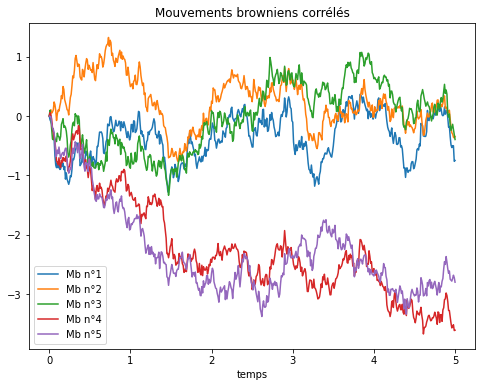

In [59]:
t,Z = CorrelatedBrownian(d,rho,sigma,T,N)
plt.subplots(figsize=(8,6))
for i in range(d):
    plt.plot(t,Z[i], label = "Mb n°{}".format(i+1))
plt.title("Mouvements browniens corrélés")
plt.xlabel("temps")
plt.legend()
plt.show()

### Evolution du prix d'un actif 
Maintenant que l'on sait comment modéliser d mouvement browniens corrélés, on peut s'intéresser à l'évolution du prix d'un actif.     
Ici on suppose que nos actifs sont solutions de l'EDS de Black-Scholes. Cette EDS possède une solution analytique qui est la suivante :    
$$
\begin{equation*}
    S_{t}^{i} = s_{0}^{i} \exp{(\sigma W_{t}^{i} + (r- \frac{\sigma^2}{2})t)}
\end{equation*}
$$

In [8]:
prixActif = lambda t,W,sigma,r, s0: s0*np.exp(sigma*W + t*(r -  (sigma**2)/2 )) 

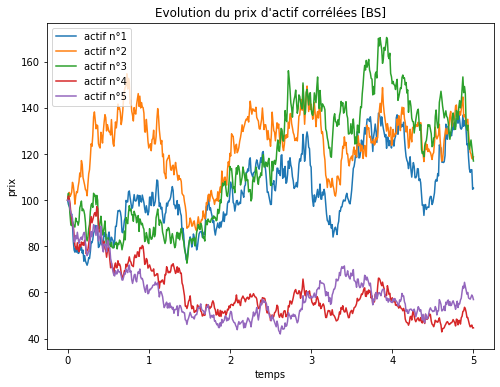

In [60]:
S = prixActif(t,Z,sigma,r,S0)

plt.subplots(figsize=(8,6))
for i in range(d):
    plt.plot(t,S[i], label = "actif n°{}".format(i+1))
plt.xlabel("temps")
plt.ylabel("prix")
plt.title("Evolution du prix d'actif corrélées [BS]")
plt.legend()
plt.show()

### Payoff de l'option
Maintenant qu'on sait générer les prix des actifs, on peut s'intéresser au calcul du payoff sur indice. Le payoff d'un call sur Indice correspond à $\bigl(I_{T} - K \bigr)_{+}$

In [9]:
# Jusqu'à présent on a considéré la matrice de prix mais comme on ne veut que le prix à maturité T (Soit S_{T} que l'on note ST)
# On aura seulement un vecteurs R^{d}
def PayoffIndice(ST,a,K):
    IT = 0
    for i in range(len(ST)):
        IT += a*ST[i]
    payoff = max(IT - K, 0)
    return payoff

In [61]:
payoff = PayoffIndice(S[:,-1],a,K)
print("Une des réalisations du payoff est : {}".format(round(payoff,2)))

Une des réalisations du payoff est : 0


### Prix du call, Monte-Carlo et son intervalle de confiance
Jusque-là on a seulement calculer une réalisation du payoff de notre indice. Toutefois on veut le prix du call, ce qui correspond à $ \mathbb{E} \Bigl[ \bigl(I_{T} - K \bigr)_{+} \Bigr] $.   
Pour cela on va passer par la méthode de Monte-Carlo. Cette méthode est basée sur la loi forte des grands nombres car on sait que pour toute variable intégrable $Z$, si on a des variables $Z_{i}$ de même loi que $Z$, on a $\overline{Z}_{M}= \frac{1}{M} \sum \limits_{\underset{}{i=0}}^M Z_i$ $ \underset{M \to +\infty}{\overset{p.s}{\longrightarrow}} \mathbb{E}[Z]$.    
Cette méthode étant probabiliste, il nous fait un intervalle de confiance de notre estimateur de $\mathbb{E}[Z]$.   
Par le TCL (Théorème Central Limite), on sait que (en rajoutant l'hypothèse que Z soit carré intégrable) $\sqrt{M} \frac{ \overline{Z}_{M}-\mathbb{E}[Z] }{ \sqrt{\mathbb{V}(Z)} } \sim \mathcal{N}(0,1)$. De ce fait on peut construire l'intervalle suivant pour $\mathbb{E}[Z]$ : 
$$
\begin{equation*}
\Bigl[ \overline{Z}_{M} - q_{\alpha}\sqrt{\frac{\mathbb{V}(Z)}{M}} ; \overline{Z}_{M} +  q_{\alpha} \sqrt{\frac{\mathbb{V}(Z)}{M}} \Bigr] \\
\text{avec } q_{\alpha} \text{le quantile d'ordre } \alpha \text{ de la loi normale centrée réduite} 
\end{equation*}
$$
Ici $Z = \bigl(I_{T} - K \bigr)_{+}$ et comme on ne connaît pas la loi du payoff, on déterminera $\mathbb{V} \Bigl[ \bigl(I_{T} - K \bigr)_{+} \Bigr]$ numériquement à partir des tirages déjà fais de $\bigl(I_{T} - K \bigr)_{+}$.

In [10]:
def IntervalleConfiance(payoffs, quartile = 1.96):
    I = np.zeros(2)
    I += payoffs.mean()
    
    var = payoffs.var()
    Mc = len(payoffs)
    
    I[0] = I[0] - quartile*np.sqrt(var/Mc)
    I[1] = I[1] + quartile*np.sqrt(var/Mc)
    return(I)

In [11]:
def PrixIndice(d, rho, sigma, r, S0, K, a, T = T,N = N, M = Mc):
    listePayoff = np.zeros(M)
    
    for i in range(M):
        t,W = CorrelatedBrownian(d,rho,sigma,T,N)
        S = prixActif(t,W,sigma,r,S0)
        payoff = PayoffIndice(S[:,-1],a,K)
        listePayoff[i] = payoff
        
    Intervalle = IntervalleConfiance(listePayoff)
    prix = listePayoff.mean()
    
    return prix,Intervalle

In [17]:
t1 = time.time()
prix,I = PrixIndice(d,rho,sigma,r,S0,K,a,T,N,1000)
t2 = time.time()
if( (t2-t1)/60 < 1 ):
    print("pour {} itérations de Monte-Carlo, temps de calcul : {}s".format( 1000, round(t2-t1,2) ))
else :
    print("pour {} itérations de Monte-Carlo, temps de calcul : {}min".format( 1000, round( (t2-t1)/60,2) ) )
    
print("On trouve un prix de : {}\nPour un intervalle de confiance à 95% : {}".format(round(prix,2),I))

pour 1000 itérations de Monte-Carlo, temps de calcul : 3.45min
On trouve un prix de : 63.46
Pour un intervalle de confiance à 95% : [57.06162972 69.85655609]


#### réduction du temps de calcul    
Si on peut remarquer quelque chose, c'est que le programme mets du temps, beaucoup de temps. Une première idée pour réduire le temps de calcul est de limiter au maximum le nombre de calculs. En effet beaucoup des opérations que l'on souhaite traiter peuvent n'être calculés qu'une fois et/ou réduites pour toutes nos itérations de Monte-Carlo.    
- La matrice de variance-covariance du mouvement brownien est indépendante de l'intération de Monte-Carlo :    
    => nécessite une **unique génération**
- La matrice de corrélation des mouvements brownien est indépendante de l'intération de Monte-Carlo :      
    => nécessite une **unique génération**
- Formule analytique pour le prix $\mathrm{S}_{t}$ **ET** la formule du payoff ne nécessite que le prix à maturité :     
    => moins de calculs (seulement le prix à l'instant T)

In [12]:
def ImprovedPriceIndex(d, rho, sigma, r, S0, K, a, T = T,N = N, M = Mc):
    Payoffs = np.zeros(M)
    
    # indépendant de MC
    t = np.array([i*(T/N) for i in range(N+1)])
    
    MatBrown = MatBrownien(t,N)
    A = np.linalg.cholesky(MatBrown[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    
    Gamma = CorrelatedMatrixBrownian(rho,d)
    A = np.linalg.cholesky(Gamma)
    
    for i in range(M):
        W = np.random.normal(0,1, size = (d,N+1))
        for j in range(d):
            W[j] = np.dot(B,W[j])
        W = W[:,-1]
        W = np.dot(A,W)
        W = prixActif(T,W,sigma,r,S0)
        Payoffs[i] = PayoffIndice(W,a,K)
        
    Intervalle = IntervalleConfiance(Payoffs)
    prix = Payoffs.mean()
    
    return prix,Intervalle

pour 100 itérations de Monte-Carlo, temps de calcul : 0.18s
pour 500 itérations de Monte-Carlo, temps de calcul : 0.26s
pour 1000 itérations de Monte-Carlo, temps de calcul : 0.36s
pour 5000 itérations de Monte-Carlo, temps de calcul : 1.17s
pour 10000 itérations de Monte-Carlo, temps de calcul : 2.11s
pour 50000 itérations de Monte-Carlo, temps de calcul : 9.36s
pour 100000 itérations de Monte-Carlo, temps de calcul : 22.01s
pour 500000 itérations de Monte-Carlo, temps de calcul : 1.77min
pour 1000000 itérations de Monte-Carlo, temps de calcul : 3.6min
pour 2000000 itérations de Monte-Carlo, temps de calcul : 7.17min


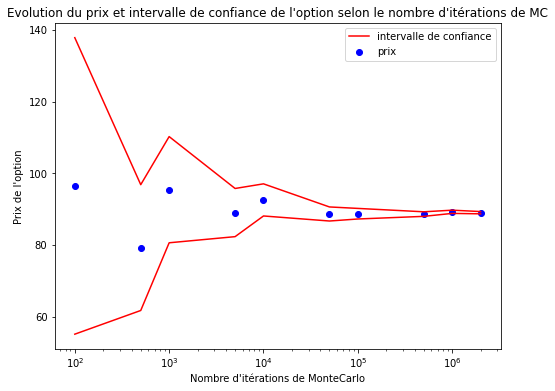

In [40]:
MonteCarlo = np.array([100,500,1000,5000,10000,50000,100000,500000,1000000,2000000])
prix = np.zeros(len(MonteCarlo))
Intervalle = np.zeros( (len(MonteCarlo),2) )


for i in range(len(MonteCarlo)):
    t1 = time.time()
    prix[i],Intervalle[i] = ImprovedPriceIndex(d,rho,sigma,r,S0,K,a,T,N,MonteCarlo[i])
    t2 = time.time()
    
    if( (t2-t1)/60 < 1 ):
        print("pour {} itérations de Monte-Carlo, temps de calcul : {}s".format( MonteCarlo[i], round(t2-t1,2) ))
    else :
        print("pour {} itérations de Monte-Carlo, temps de calcul : {}min".format( MonteCarlo[i], round( (t2-t1)/60,2) ) )

plt.subplots(figsize=(8,6))
plt.scatter(MonteCarlo,prix, color = "b", label = "prix")
plt.plot(MonteCarlo, Intervalle[:,0], color = 'r', label = "intervalle de confiance")
plt.plot(MonteCarlo, Intervalle[:,1], color = 'r')

plt.xlabel("Nombre d'itérations de MonteCarlo")
plt.ylabel("Prix de l'option")
plt.title("Evolution du prix et intervalle de confiance de l'option selon le nombre d'itérations de MC")
plt.xscale('log')
plt.legend()
plt.show()

#### Variation du prix du call 
Si on s'intéresse à la variation du prix de l'option par rapport au strike $K$:

pour 400000 itérations de Monte-Carlo, temps de calcul : 1.5min


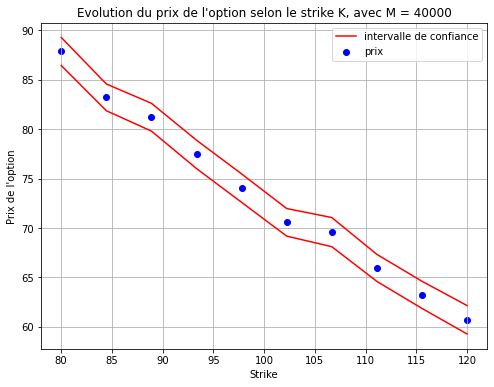

In [20]:
listeStrike = np.linspace(80,120,10)
prix = np.zeros(len(listeStrike))
Liste_Intervalle = np.zeros( (len(listeStrike),2) )

t1 = time.time()
for i in range(len(listeStrike)):
    prix[i],Liste_Intervalle[i] = ImprovedPriceIndex(d,rho,sigma,r,S0,listeStrike[i],a,T,N,Mc)
t2 = time.time()

if( (t2-t1)/60 < 1 ):
    print("pour {} itérations de Monte-Carlo, temps de calcul : {}s".format(Mc*len(listeStrike), round(t2-t1,2) ))
else:
    print("pour {} itérations de Monte-Carlo, temps de calcul : {}min".format( Mc*len(listeStrike), round( (t2-t1)/60,2) ) )

plt.subplots(figsize=(8,6))
plt.plot(listeStrike, Liste_Intervalle[:,0], color = 'r', label = "intervalle de confiance")
plt.plot(listeStrike, Liste_Intervalle[:,1], color = 'r')
plt.scatter(listeStrike,prix, color = 'b', label = "prix")
plt.xlabel("Strike")
plt.ylabel("Prix de l'option")
plt.title("Evolution du prix de l'option selon le strike K, avec M = {}".format(Mc))
plt.legend()
plt.grid()
plt.show()

Maintenant qu'on a un programme un peu moins gournmand en temps de calcul, on peut aller un peu plus loin et se demander comment évolue le prix de notre option selon le strike $K$ et selon la maturité $\mathrm{T}$

temps de calcul : 41.85min, pour 40000 itérations de Monte-Carlo


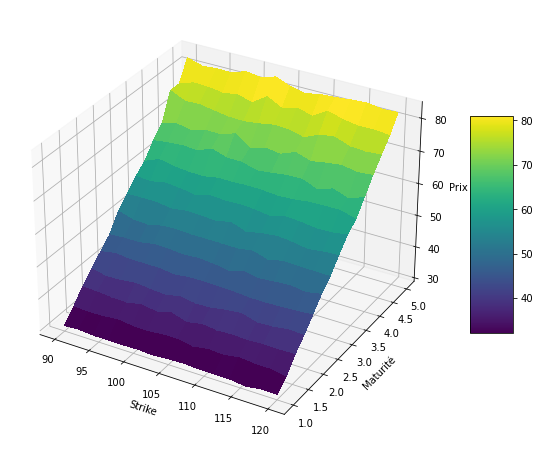

In [27]:
Strike_data = np.linspace(90,120,15)
Maturite_data = np.linspace(1,5,15)
STRIKE,MATURITE = np.meshgrid(Strike_data, Maturite_data)

PRICE = np.zeros( (len(Strike_data),len(Maturite_data)) )
t1 = time.time()
for i in range(len(Strike_data)):
    for j in range(len(Maturite_data)):
        PRICE[i][j] = ImprovedPriceIndex(d,rho,sigma,r,S0,Strike_data[i],a,Maturite_data[i],N,Mc)[0]
t2 = time.time()

if( (t2-t1)/60 < 1 ):
    print("temps de calcul : {}s, pour {} itérations de Monte-Carlo".format( round(t2-t1,2), Mc*len(Strike_data)*len(Maturite_data) ))
else :
    print("temps de calcul : {}min, pour {} itérations de Monte-Carlo".format( round( (t2-t1)/60,2), Mc*len(Strike_data)*len(Maturite_data) ) )


fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(STRIKE, MATURITE, PRICE, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturité")
ax.set_zlabel("Prix")
ax.set_title("Evolution du prix selon la maturité et le strike")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

On peut aussi de la même manière se demander comment évolue le prix de notre option si on fait varier à la fois $\rho$ et la volatiltié $\sigma$ de nos actifs

temps de calcul : 51.53min, pour 12500000 itérations de Monte-Carlo


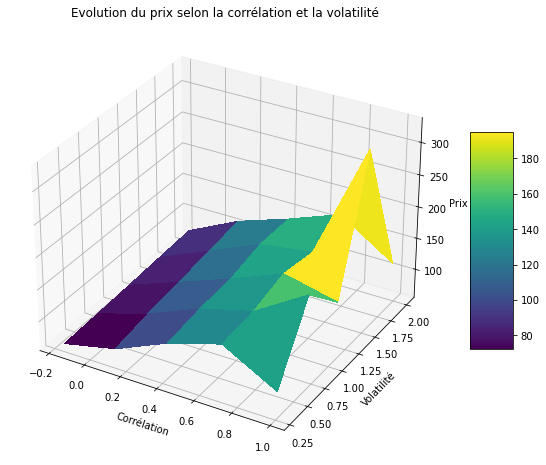

In [67]:
Rho_data = np.linspace(-1/(d+1) , 0.99, 5 )
Sigma_data = np.linspace(0.3, 2, 5 )
RHO, SIGMA = np.meshgrid(Rho_data, Sigma_data)

PRICE = np.zeros( (len(Rho_data),len(Sigma_data)) )
t1 = time.time()
for i in range(len(Rho_data)):
    for j in range(len(Sigma_data)):
        PRICE[i][j] = ImprovedPriceIndex(d,Rho_data[i],Sigma_data[j],r,S0,K,a,T,N,Mc)[0]
t2 = time.time()

if( (t2-t1)/60 < 1 ):
    print("temps de calcul : {}s, pour {} itérations de Monte-Carlo".format( round(t2-t1,2), Mc*len(Rho_data)*len(Sigma_data) ))
else :
    print("temps de calcul : {}min, pour {} itérations de Monte-Carlo".format( round( (t2-t1)/60,2), Mc*len(Rho_data)*len(Sigma_data) ) )


fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(RHO, SIGMA, PRICE, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel("Corrélation")
ax.set_ylabel("Volatilité")
ax.set_zlabel("Prix")
ax.set_title("Evolution du prix selon la corrélation et la volatilité")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Réduction de Variance
Maintenant qu'on sait générer nos prix,on remarque que la taille de l'intervalle de confiance dépend du rapport : $\frac{\mathbb{V} \bigl[ \bigl(I_{T} - K \bigr)_{+} \bigr]}{M}$. Donc pour réduire la taille de notre intervalle, on doit soit jouer sur $M$ soit sur $\mathbb{V} \bigl[ \bigl(I_{T} - K \bigr)_{+} \bigr]$. Etant donné que l'on gagne très peu en augmentant $M$ car notre estimateur converge à une vitesse $\sqrt{M}$, on peut s'intéresser à jouer sur la valeur de $\mathbb{V} \bigl[ \bigl(I_{T} - K \bigr)_{+} \bigr]$. C'est le but des méthodes de réduction de variance que nous allons voir.

### Variables antithétiques

#### principe de fonctionnement
Le principe de réduction de la variance par variable antithétique est le suivant :   

On souhaite calculer $\mathbb{E} \bigl[ f(X) \bigr]$. On approche cette espérance par la loi des grands nombres en considérant des tirages $X_i$ de X. i.e $\frac{1}{M} [f(X_1) + ... f(X_M)] {\underset{M \to +\infty}{\overset{p.s}{\longrightarrow}}} \mathbb{E}[f(X)] $    

Si on considère deux estimateurs $m_{1}$ et $m_{2}$ de $\mathbb{E} \bigl[ f(X) \bigr]$ tel que :    
$$
\begin{equation*}
    m_{1} = \frac{1}{M} \bigl( f(X_{1}) + ... f(X_{M}) \bigr) \\
    m_{2} = \frac{1}{M} \bigl( f(\mathrm{T}(X_{1})) + ... f(\mathrm{T}(X_{M})) \bigr)  
\end{equation*}
$$
  
avec $\mathrm{T}$ une transformation tel que $ \mathrm{T}(X) \overset{loi}{=} X$    
Avec cela nous avons :
$$
\begin{equation*}
    \mathbb{V} \bigl[ \frac{m_1 + m_2}{2} \bigr] = \frac{\mathbb{V} [m_1] + \mathbb{V} [m_2] + 2Cov[m_1,m_2]}{4}
\end{equation*}
$$ 
Si $\mathrm{T}$ = identité p.s, alors $\mathbb{V} \bigl[ \frac{m_1 + m_2}{2} \bigr] =  \mathbb{V} \bigl[ m_1 \bigr]$.   
Mais si on trouve $\mathrm{T}$ tel que $Cov[\mathrm{T}(f(X)),f(X)] \leq  0$ alors $ Var[\frac{m_1 + m_2}{2}] \leq Var[m_1] $. C'est l'idée derrière la technique de réduction de la variance par variable antithétique. 

#### notre transformation
Ici on peut voir le prix $S_{t}$ de notre actif comme une fonction de $W_{t}$ donc $S_{t} = f(t,W_{t})$. avec $f : (t,x) \rightarrow s_{0} \exp{(\sigma x + (r- \frac{\sigma^2}{2})t)}$.    


Une transformation naturelle à considérer est : $\mathrm{T} : x \rightarrow -x$. En effet Comme $\forall t > 0, W_{t} \sim \mathcal{N}(0,t)$, par symétrie de la loi normale, $-W_{t} \sim \mathcal{N}(0,t)$. Donc on a :
$$
\begin{align*}
    Cov[T(W_{t}),W_{t}] &= Cov[- W_{t},W_{t}]  \\
    &= - \mathbb{V} \bigl[ W_{t} \bigr] \\
    &= -t \\
    &< 0
\end{align*}
$$
Cela semble bien partir pour prendre cette transformation. Toutefois on ne veut pas que $ Cov[T(W_{t}),W_{t}]  \leq 0$ mais que ce soit : $ Cov[f(t,\mathrm{T}(W_{t})),f(t,W_{t})] \leq 0$. Il faut donc voir si certaines propriétés nous permettent cela.    

Posons : $g$ tel que $\forall t \geq 0$ , $g(t,.) = f(t,T(.))$    
comme f est une fonction décroissante en x, g est une fonction croissante en x. On considère $Z$ et $Y$, deux variables aléatoires indépendantes et de même loi.
$$
\begin{align*}
    \text{On a donc :} \quad \mathbb{E} \bigl[ \bigl( f(Z)-f(Y) \bigr) \bigl( g(Z)-g(Y) \bigr) \bigr] &\leq 0 \\
    \Rightarrow \quad \mathbb{E} \big[ f(Z)g(Z) \bigr] + \mathbb{E} \bigl[ f(Y)g(Y) \bigr] &\leq \mathbb{E} \bigl[ f(Z)g(Y) \bigr] + \mathbb{E} \bigl[ f(Y)g(Z) \bigr] \\
    \mathbb{E}\bigl[ f(Z)g(Z) \bigr] &\leq \mathbb{E} \bigl[ f(Z) \bigr] \mathbb{E} \bigl[ g(Z) \bigr] \quad \text{car v.a i.i.d} \\ 
    \text{Donc} \quad Cov[f(Z),g(Z)] &= \mathbb{E}[f(Z)g(Z)] - \mathbb{E}[f(Z)] \mathbb{E}[g(Z)] \leq 0
\end{align*}
$$
Notre transformation est donc légitime et marche bien.

In [13]:
def PrixIndiceAntithetique(d, rho, sigma, r, S0, K, a, T,N = N, M = Mc):
    Payoffs = np.zeros(int(2*M))

    # indépendant de MC
    t = np.array([i*(T/N) for i in range(N+1)])
    
    MatBrown = MatBrownien(t,N)
    A = np.linalg.cholesky(MatBrown[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    
    Gamma = CorrelatedMatrixBrownian(rho,d)
    A = np.linalg.cholesky(Gamma)
    
    for i in range(M):
        W = np.random.normal(0,1, size = (d,N+1))
        for j in range(d):
            W[j] = np.dot(B,W[j])
        W = W[:,-1]
        W = np.dot(A,W)
        Z = -W
        
        W = prixActif(T,W,sigma,r,S0)
        Z = prixActif(T,Z,sigma,r,S0)
        
        Payoffs[i] = PayoffIndice(W,a,K)
        Payoffs[i+M] = PayoffIndice(Z,a,K)
   
    Intervalle = IntervalleConfiance(Payoffs)
    prix = Payoffs.mean()

    
    return prix,Intervalle

In [14]:
def ComparaisonPrixIndice(d, rho, sigma, r, S0, K, a, T,N = N, M = Mc):
    PayoffsAnti = np.zeros(int(2*M))
    PayoffsNormal = np.zeros(M)
    
    # indépendant de MC
    t = np.array([i*(T/N) for i in range(N+1)])
    
    MatBrown = MatBrownien(t,N)
    A = np.linalg.cholesky(MatBrown[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    
    Gamma = CorrelatedMatrixBrownian(rho,d)
    A = np.linalg.cholesky(Gamma)
    
    for i in range(M):
        W = np.random.normal(0,1, size = (d,N+1))
        for j in range(d):
            W[j] = np.dot(B,W[j])
        W = W[:,-1]
        W = np.dot(A,W)
        Z = -W
        
        W = prixActif(T,W,sigma,r,S0)
        Z = prixActif(T,Z,sigma,r,S0)
        
        PayoffsAnti[i] = PayoffIndice(W,a,K)
        PayoffsAnti[i+M] = PayoffIndice(Z,a,K)
        
        PayoffsNormal[i] = PayoffsAnti[i]
        
    
    IntervalleAnti = IntervalleConfiance(PayoffsAnti)
    IntervalleNormal = IntervalleConfiance(PayoffsNormal)
    prixAnti = PayoffsAnti.mean()
    prixNormal = PayoffsNormal.mean()
    
    return prixNormal,prixAnti,IntervalleNormal,IntervalleAnti

Maintenant on peut comparer notre version avec variable antithétique et sans variable antithétique. On va donc voir ça visuellement pour différents nombre d'itérations de Monte-Carlo et on va aussi regarder la longueur de notre intervalle de confiance.

temps de calcul : 15.54min, pour 8000000 itérations de Monte-Carlo


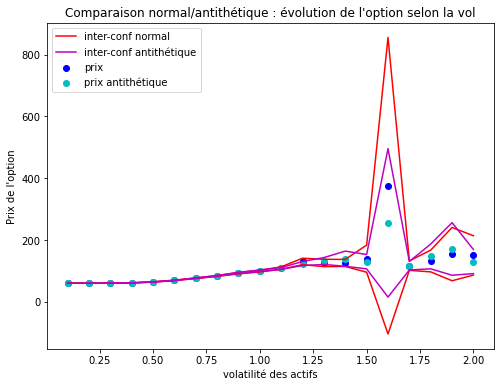

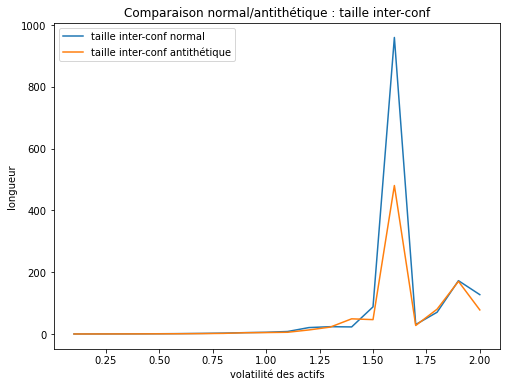

In [14]:
vol = np.linspace(0.1,2,20)

prix = np.zeros(len(vol))
prixAntithetique = np.zeros(len(vol))

Liste_Intervalle_Antithetique = np.zeros( (len(vol),2) )
Liste_Intervalle = np.zeros( (len(vol),2) )

t1 = time.time()
for i in range(len(vol)):
    prix[i],prixAntithetique[i],Liste_Intervalle[i], Liste_Intervalle_Antithetique[i] = ComparaisonPrixIndice(d,rho,vol[i],r,S0,K,a,T,N,Mc)
t2 = time.time()

plt.subplots(figsize=(8,6))

if( (t2-t1)/60 < 1 ):
    print("temps de calcul : {}s, pour {} itérations de Monte-Carlo".format( round(t2-t1,2), 2*Mc*len(vol) ) )
else :
    print("temps de calcul : {}min, pour {} itérations de Monte-Carlo".format( round( (t2-t1)/60,2), 2*Mc*len(vol) ) )

# plot du calcul naif 
plt.plot(vol, Liste_Intervalle[:,0], color = 'r', label = "inter-conf normal")
plt.plot(vol, Liste_Intervalle[:,1], color = 'r')
plt.scatter(vol,prix, color = 'b', label = "prix")

# plot du calcul avec réduction de variance
plt.plot(vol, Liste_Intervalle_Antithetique[:,0], color = 'm', label = "inter-conf antithétique")
plt.plot(vol, Liste_Intervalle_Antithetique[:,1], color = 'm')
plt.scatter(vol, prixAntithetique, color = 'c', label = "prix antithétique")

plt.xlabel("volatilité des actifs")
plt.ylabel("Prix de l'option")
plt.title("Comparaison normal/antithétique : évolution de l'option selon la vol")
plt.legend()
plt.show()

LongueurIntervalle1 = np.zeros(len(vol))
LongueurIntervalle2 = np.zeros(len(vol))
for i in range(len(vol)):
    LongueurIntervalle1[i] = Liste_Intervalle[i,1]-Liste_Intervalle[i,0]
    LongueurIntervalle2[i] = Liste_Intervalle_Antithetique[i,1]-Liste_Intervalle_Antithetique[i,0]
    
plt.subplots(figsize=(8,6))
plt.plot(vol,LongueurIntervalle1, label = "taille inter-conf normal")
plt.plot(vol,LongueurIntervalle2, label = "taille inter-conf antithétique")
plt.xlabel("volatilité des actifs")
plt.ylabel("longueur")
plt.title("Comparaison normal/antithétique : taille inter-conf")
plt.legend()
plt.show()

On remarque que pour n'importe quelle volatilité de nos actifs, notre méthode de réduction par variable antithétique semble bien  donner un résultat plus précis que la méthode naïve (sans réduction de variance)

### Variable de contrôle

#### principe de fonctionnement       
On souhaite estimer $\mathcal{J} = \mathbb{E} \Bigl[ X \Bigr] $.    
On suppose que l'a aussi une autre variable aléatoire $Y$.   
Soit $\beta \in \mathbb{R}$, on considère : $X - \beta Y + \beta \mathbb{E} \Bigl[ Y \Bigr] $. On peut voir que cette variable aléatoire est d'espérance : $\mathcal{J}$ : 
$$
\begin{align*}
    \mathbb{E} \Bigl[ X - \beta Y + \beta \mathbb{E} \Bigl[ Y \Bigr] \Bigr] &= \mathbb{E} \Bigl[ X \Bigr] - \beta \Bigl( \mathbb{E} \Bigl[ Y - \mathbb{E} \Bigl[ Y \Bigr] \Bigr] \Bigl) \\
    &= \mathcal{J}
\end{align*}
$$


Maintenant on peut s'intéresser à la variance de ce nouvel estimateur : 
$$
\begin{align*}
    \mathbb{V} \bigl[  X - \beta Y + \beta \mathbb{E} \bigl[ Y \bigr] \bigr] &= \mathbb{V} \bigl[  X - \beta Y + \beta \mathbb{E} \bigl[ Y \bigr] \bigr] \\
    &=\mathbb{V} \bigl[  X - \beta Y \bigr] &\quad \text{car } \mathbb{V} \bigl[X + a \bigr] = \mathbb{V} \bigl[X \bigr] \\
    &= \mathbb{V} \bigl[ X \bigr] + \beta^{2} \mathbb{V} \bigl[ Y \bigr] - 2 \beta Cov(X,Y) \\
    &= \beta^{2} \mathbb{V} \bigl[ Y \bigr] - 2 \beta Cov(X,Y) + \mathbb{V} \bigl[ X \bigr] \\
\end{align*}
$$

On remarque que cette estimateur est une fonction polynomiale d'ordre 2 en $\beta$. De plus cette fonction admet un minimum global en $\beta^{*} = \frac{Cov(X,Y)}{\mathbb{V} \bigl[ Y \bigr]} $. Si on remplace $\beta$ par $\beta^{*}$, on trouve une variance de :   
$$
\begin{equation*}
    \mathbb{V} \bigl[  X - \beta^{*} Y + \beta^{*} \mathbb{E} \bigl[ Y \bigr] \bigr] = \bigl( 1 - \rho_{X,Y}^{2} \bigr) \mathbb{V} \bigl[ X \bigr] \quad \rho_{X,Y} \text{ la corrélation entre X et Y}
\end{equation*}
$$
On remarque donc que pour n'importel quelle valeur de $\rho_{X,Y}$ notre nouvel estimateur de $\mathcal{J}$ a une variance plus faible que l'estimateur originale. Et plus en valeur absolue, $X$ et $Y$ sont corrélés, plus la variance de notre nouvel estimateur est faible.    
Finalement on peut approcher $\mathcal{J}$ par $ \mathcal{\tilde J}_{M} $ tel que :   
$$
\begin{equation*}
    \mathcal{\tilde J}_{M} = \frac{1}{M} \sum_{i=1}^{M} \bigl( X_{i} - \beta^{*} Y_{i} \bigr) + \beta^{*} \mathbb{E} \bigl[ Y \bigr]  
\end{equation*}
$$
avec $X_{i}$ des v.a i.i.d de même loi que $X$ et $Y_{i}$ des v.a i.i.d de même loi que Y.

### notre variable de contrôle
Ici nous prendrons la variable de contrôle $\mathrm{Y} = \bigl( \exp(\mathrm{Z}_{T}) - K \bigr)_{+}$    
avec $Z_{T} = a_{1} \frac{S_{0}^{1}}{I_{0}} log \bigl( \frac{S_{T}^{1}}{S_{0}^{1}} \bigr) + ... + a_{d} \frac{S_{0}^{d}}{I_{0}} log \bigl( \frac{S_{T}^{d}}{S_{0}^{d}} \bigr)$     
Nous allons commencer à nous intéresser à la loi de $Z_{T}$.   
$$
\begin{equation*}
    Z_{T} = \frac{a_{1} S_{0}^{1}}{I_{0}} log \left( \frac{S_{T}^{1}}{S_{0}^{1}} \right) + ... + \frac{a_{d} S_{0}^{d}}{I_{0}} log \left( \frac{S_{T}^{d}}{S_{0}^{d}} \right) 
\end{equation*}
$$
Intéréssons-nous à $log \left( \frac{S_{T}^{i}}{S_{0}^{i}} \right)$
$$
\begin{align*}
    log \left( \frac{S_{T}^{1}}{S_{0}^{1}} \right) &= log \left( \frac{S_{0}^{i}}{S_{0}^{i}} exp \left( \sigma_{i} W_{T}^{i} + \left( r - \frac{\sigma_{i}^{2}}{2} \right) T \right) \right) \\
    &= log \left( exp \left( \sigma W_{T}^{i} + \left( r - \frac{\sigma_{i}^{2}}{2} \right) T \right) \right) \\
    &=  \sigma W_{T}^{i} + \left( r - \frac{\sigma^{2}}{2} \right) T
\end{align*}
$$

$$
\begin{align*}
    Z_{T} &= \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} log \bigl( \frac{S_{T}^{i}}{S_{0}^{i}} \bigr) \\
    &= \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \Bigl( \sigma_{i} W_{T}^{i} + \bigl( r - \frac{\sigma_{i}^{2}}{2}  \bigr) T\Bigr) \\
    &= \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} + \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T
\end{align*}
$$

$Z_{T}$ est une somme de mouvements browniens donc de loi normales. Donc par stabilité de la loi normale, $Z_{T} \sim \mathcal{N}(\mu,\tilde \sigma ^{2})$

$$
\begin{align*}
    \mu &= \mathbb{E} \Bigl[ Z_{T} \Bigr] \\
        &= \mathbb{E} \Bigl[ \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} + \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T  \Bigr] \\ 
        &= \mathbb{E} \Bigl[ \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} \Bigr] + \mathbb{E} \Bigl[\sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T  \Bigr] \\
        &= \mathbb{E} \Bigl[\sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T  \Bigr] &\quad \text{car } \mathbb{E}\Bigl[ W_{T}^{i} \Bigr] = 0 \\
        &= \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T
\end{align*}
$$

en rajoutant les hypothèses suivantes : $a_{1} = ... = a_{d} = a$ , $ \sigma_{1} = ... = \sigma_{d} = \sigma$ et $S_{0}^{1} = ... = S_{0}^{d} = S_{0}$, on a : 

$$
\begin{align*}
    \mu &= \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T \\
    &= \sum_{i=1}^{d} \frac{a S_{0}}{I_{0}} \bigl( r - \frac{\sigma^{2}}{2} \bigr) T \\
    &= d \frac{a S_{0}}{I_{0}} \bigl( r - \frac{\sigma^{2}}{2} \bigr) T \\
    &= T \bigl( r - \frac{\sigma^{2}}{2} \bigr) &\quad \text{car } d a S_{0} = I_{0}
\end{align*}
$$

$$
\begin{align*}
    \tilde \sigma^{2} &= \mathbb{V} \Bigl[ Z_{T} \Bigr] \\  
    &= \mathbb{V} \Bigl[ \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} + \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \bigl( r - \frac{\sigma_{i}^{2}}{2} \bigr) T  \Bigr] \\
    &= \mathbb{V} \Bigl[ \sum_{i=1}^{d} \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} \Bigr] &\quad \mathbb{V} \Bigl[ X+c \Bigr] = \mathbb{V} \Bigl[ X \Bigr] \\
    &= \sum_{i=1}^{d} \mathbb{V} \Bigl[ \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} \Bigr] + 2 \sum_{i=1}^{d} \sum_{j=1}^{i-1} Cov \Bigl[ \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} W_{T}^{i} , \frac{a_{j} S_{0}^{j}}{I_{0}} \sigma_{j} W_{T}^{j} \Bigr] \\
    &= \sum_{i=1}^{d} \Bigl( \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} \Bigr)^{2} \mathbb{V} \Bigl[ W_{T}^{i} \Bigr] + \frac{2}{I_{0}^{2}} \sum_{i=1}^{d} \sum_{j=1}^{i-1} a_{i}  a_{j} S_{0}^{i} S_{0}^{j} \sigma_{i} \sigma_{j} Cov \Bigl[   W_{T}^{i} , W_{T}^{j} \Bigr] \\
    &= \sum_{i=1}^{d} \Bigl( \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} \Bigr)^{2} T + \frac{2}{I_{0}^{2}} \sum_{i=1}^{d} \sum_{j=1}^{i-1} a_{i}  a_{j} S_{0}^{i} S_{0}^{j} \sigma_{i} \sigma_{j} \rho_{i,j}  
\end{align*}
$$

en rajoutant les hypothèses suivantes : $a_{1} = ... = a_{d} = a$ , $ \sigma_{1} = ... = \sigma_{d} = \sigma$ et $S_{0}^{1} = ... = S_{0}^{d} = S_{0}$, $\rho_{i,j} = \rho \forall i \ne j$ on a : 

$$
\begin{align*}
    \tilde \sigma^{2} &= \sum_{i=1}^{d} \Bigl( \frac{a_{i} S_{0}^{i}}{I_{0}} \sigma_{i} \Bigr)^{2} T + \frac{2}{I_{0}^{2}} \sum_{i=1}^{d} \sum_{j=1}^{i-1} a_{i}  a_{j} S_{0}^{i} S_{0}^{j} \sigma_{i} \sigma_{j} \rho_{i,j}T \\
    &= \Bigl( \frac{a S_{0}}{I_{0}} \sigma \Bigr)^{2} T d + \frac{2}{I_{0}^{2}} a^{2}  S_{0}^{2} \sigma^{2} \rho T d (d-1) \\
    &= \Bigl( \frac{a S_{0}}{I_{0}} \sigma \Bigr)^{2} T d + 2 \Bigl( \frac{a S_{0}}{I_{0}} \sigma \Bigr)^{2} T \rho d (d-1) \\
    &= T d \Bigl( \frac{a S_{0}}{I_{0}} \sigma \Bigr)^{2} \Bigl[ 1 + 2 \rho (d-1) \Bigr] 
\end{align*}
$$

Maintenant on peut s'intéresser à calculer $\mathbb{E} \Bigl[ Y \Bigr]$ 
$$
\begin{align*}
    \mathbb{E} \Bigl[ Y \bigr] &= \mathbb{E} \Bigl[ \bigl( exp(Z_{T}) - K \bigr)_{+} \bigr] \\
    &= \mathbb{E} \Bigl[ \bigl( exp(Z_{T}) - K \bigr) \mathrm{1}_{ \{exp(Z_{T}) > K \} }  \bigr] \\
    &= \mathbb{E} \Bigl[  exp(Z_{T}) \mathrm{1}_{ \{exp(Z_{T}) > K \} }  \bigr] - K \mathbb{E} \Bigl[ \mathrm{1}_{ \{exp(Z_{T}) > K \} }  \bigr] \\
    &= \mathbb{E} \Bigl[ exp(Z_{T}) \mathrm{1}_{ \{exp(Z_{T}) > K \} }  \bigr] - K \mathbb{P} \Bigl[ exp(Z_{T}) > K \bigr] \\
    &= A - K B
\end{align*}
$$
Calculons d'une part $B$ :
$$
\begin{align*}
    B &= \mathbb{P} \Bigl[ exp(Z_{T}) > K \bigr] \\
      &= \mathbb{P} \Bigl[ Z_{T} > ln(K) \bigr] &\quad \text{car ln est une fonction croissante} \\
      &= \mathbb{P} \Bigl[ \mu + \tilde \sigma G > ln(K) \bigr] \\
      &= \mathbb{P} \Bigl[  G > \frac{ln(K) - \mu}{ \tilde \sigma} \bigr] \\
      &= \mathbb{P} \Bigl[  - G < - \frac{ln(K) - \mu}{ \tilde \sigma} \bigr] \\
      &= \mathbb{P} \Bigl[   G < \frac{\mu - ln(K)}{ \tilde \sigma} \bigr] &\quad \text{par symétrie de la loi normale centrée réduite} \\
      &= \mathcal{N} \bigl( \frac{\mu - ln(K)}{ \tilde \sigma} \bigr) \\
      &= \mathcal{N} \bigl( d_{2} \bigr) &\quad d_{2} = \frac{\mu - ln(K)}{ \tilde \sigma}  \\
\end{align*}
$$
Calculons maintenant A : 
$$
\begin{align*}
    A &= \mathbb{E} \Bigl[  exp(Z_{T}) \mathrm{1}_{ \{exp(Z_{T}) > K \} }  \bigr] \\
      &= \mathbb{E} \Bigl[  exp(Z_{T}) \mathrm{1}_{ \{ G > - d_{2} \} }  \bigr] \\
      &= \mathbb{E} \Bigl[ exp \bigl( \mu + \tilde \sigma G \bigr)  \mathrm{1}_{ \{ G > - d_{2} \} } \Bigr] \\
      &= \int_{-d_{2}}^{+ \infty} \frac{1}{\sqrt{2 \pi}} e^{\mu + \tilde \sigma x} e^{-\frac{x^{2}}{2}} \mathrm{d}x &\quad \text{théorème de transfert} \\
      &= \frac{1}{\sqrt{2 \pi}} e^{\mu} \int_{-d_{2}}^{+ \infty} e^{-\frac{x^{2}}{2} + \tilde \sigma x} \mathrm{d}x \\
      &= \frac{e^{\mu}}{\sqrt{2 \pi}} \int_{-d_{2}}^{+ \infty} e^{-\frac{x^{2}}{2} + \tilde \sigma x} \mathrm{d}x \\
      &= \frac{e^{\mu}}{\sqrt{2 \pi}} \int_{-d_{2}}^{+ \infty} e^{-\frac{1}{2} ( x^{2} - 2 \tilde \sigma x) } \mathrm{d}x \\
      &= \frac{e^{\mu + \frac{1}{2} \tilde \sigma^{2}}} {\sqrt{2 \pi}} \int_{-d_{2}}^{+ \infty} e^{-\frac{1}{2} ( x -  \tilde \sigma )^{2} } \mathrm{d}x \\
      &= \frac{e^{\mu + \frac{1}{2} \tilde \sigma^{2}}} {\sqrt{2 \pi}}  \int_{-d_{2} - \tilde \sigma}^{+ \infty} e^{-\frac{1}{2} y^{2} } \mathrm{d}y &\quad \text{changement de variable : } y = x - \tilde \sigma \text{, légitime car affine} \\
      &= e^{\mu + \frac{1}{2} \tilde \sigma^{2}} \int_{-d_{2} - \tilde \sigma}^{+ \infty} \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} y^{2} } \mathrm{d}y \\
      &= e^{\mu + \frac{1}{2} \tilde \sigma^{2}} \mathbb{P} \Bigl( G > -d_{2} - \tilde \sigma \Bigr) \\
      &= e^{\mu + \frac{1}{2} \tilde \sigma^{2}} \mathbb{P} \Bigl( - G < d_{2} + \tilde \sigma \Bigr) \\
      &= e^{\mu + \frac{1}{2} \tilde \sigma^{2}} \mathbb{P} \Bigl(  G < d_{2} + \tilde \sigma \Bigr) &\quad \text{par symétrie de la loi normale centrée réduite} \\
      &= e^{\mu + \frac{1}{2} \tilde \sigma^{2}} \mathcal{N} \bigl( d_{1} \bigr) &\quad d_{1} = d_{2} + \tilde \sigma \\
\end{align*}
$$
Donc finalement on trouve la formule suivante : 
$$
\begin{equation*}
    \mathbb{E} \Bigl[ Y \Bigr] = e^{ \mathbb{E}[Z_{T}] + \frac{1}{2} \mathbb{V}[Z_{T}] } \mathcal{N} \bigl( d_{1} \bigr) - K \mathcal{N} \bigl( d_{2} \bigr) 
\end{equation*}
$$

Si on revient à notre estimateur $\mathcal{\tilde J}_{M} = \frac{1}{M} \sum_{i=1}^{M} \bigl( X_{i} - \beta^{*} Y_{i} \bigr) + \beta^{*} \mathbb{E} \bigl[ Y \bigr]$, on peut le réecrire sous la forme :    
$$
\begin{equation*}
    \mathcal{\tilde J}_{M} = \frac{1}{M} \sum_{i=1}^{M} \bigl( X_{i} - \beta^{*} Y_{i} \bigr) + \beta^{*} \Bigl( e^{ \mathbb{E}[Z_{T}] + \frac{1}{2} \mathbb{V}[Z_{T}] } \mathcal{N} \bigl( d_{1} \bigr) - K \mathcal{N} \bigl( d_{2} \bigr)  \Bigr)
\end{equation*}
$$
On remarque que : $\mathbb{E} \bigl[ Z_{T} \bigr]$ et $\mathbb{V} \bigl[ Z_{T} \bigr]$ sont calculables à la main. $\mathcal{N} \bigl( d_{2} \bigr)$ et $\mathcal{N} \bigl( d_{1} \bigr)$ doivent être calculés numériquement.   
Maintenant on peut s'intéresser à $B^{*}$. Etant donné que nous n'avons pas de formule analytique sous la main, on l'approchera par son estimateur empirique $B_{M}^{*}$

In [15]:
def Controle(S0,ST,a,d,K,I0):
    Zt = 0
    for i in range(d):
        Zt += a * (S0/I0) * np.log(ST[i]/S0)
        
    Y = np.exp(Zt) - K 
    varControle = Y*(Y > 0)
    return( varControle )

In [16]:
def ControleVariable(d, rho, sigma, r, S0, K, a, T,N = N, M = Mc):
    X = np.zeros(M)
    Y = np.zeros(M) # variable de contrôle
    
    I0 = S0
    
    mu = (r - ((sigma**2)/2) )*T
    
    sigmaTilde = ( sigma*a*S0/I0 ) * np.sqrt( T*d ) * np.sqrt( 1 + 2*rho*(d-1) ) 
    
    print("sigmaTilde = ", sigmaTilde)
    print("mu = ", mu)
    
    d2 = ( mu - np.log(K) )/sigmaTilde 
    d1 = d2 + sigmaTilde
    
    print("d1 = ", d1)
    print("d2 = ", d2)
    
    Nd1 = (np.random.normal(size = M) <= (d1) ).mean()
    Nd2 = (np.random.normal(size = M) <= (d2) ).mean() 
    EspY = np.exp( mu + (sigmaTilde**2)/2 )*Nd1 - K*Nd2 
    
    # indépendant de MC
    t = np.array([i*(T/N) for i in range(N+1)])
    
    MatBrown = MatBrownien(t,N)
    A = np.linalg.cholesky(MatBrown[1:,1:])
    B = np.zeros((N+1,N+1))
    B[1:,1:] = A
    
    Gamma = CorrelatedMatrixBrownian(rho,d)
    A = np.linalg.cholesky(Gamma)
    
    for i in range(M):
        W = np.random.normal(0,1, size = (d,N+1))
        for j in range(d):
            W[j] = np.dot(B,W[j])
        W = W[:,-1]
        W = np.dot(A,W)
        
        S = prixActif(T,W,sigma,r,S0)
        
        X[i] = PayoffIndice(S,a,K)
        Y[i] = Controle(S0,S,a,d,K,I0)
   
    Z = np.cov(X,Y)
    Beta_opti = Z[0][1]/Z[1][1]
    payoff = X - Beta_opti*Y + Beta_opti*EspY
    print("Nd1 = {}\nNd2 = {}".format(Nd1,Nd2))
    print("EspY vaut : {}\nE[Y] vaut : {}".format(EspY,Y.mean()))
        
    Intervalle = IntervalleConfiance(payoff)
    prix = payoff.mean()

    return prix,Intervalle

In [17]:
prix,Intervalle = ControleVariable(d, rho, sigma, r, S0, K, a, T, N, Mc)
print(prix)
print(Intervalle)

sigmaTilde =  0.30000000000000004
mu =  0.05500000000000001
d1 =  -15.029867833858408
d2 =  -15.329867833858408


C:\Users\Imad\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


Nd1 = 0.0
Nd2 = 0.0
EspY vaut : 0.0
E[Y] vaut : 0.0
nan
[nan nan]
